<a href="https://colab.research.google.com/github/davut1999/Document-ChatGPT/blob/main/stock_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import os

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [118]:
store_sales= pd.read_csv("train.csv")

In [119]:
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


check for null values in dataset

In [120]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


dropping store and item columns

In [121]:
store_sales=store_sales.drop(["store","item"],axis=1)

In [122]:
store_sales.head(5)

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


convert date datatype from object to datetime

In [123]:
store_sales["date"]=pd.to_datetime(store_sales["date"])

In [124]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [125]:
#predictingsales on next month. convet date to month period and then sum number of items in each month

In [126]:
store_sales["date"]=store_sales["date"].dt.to_period("M")
monthly_sales=store_sales.groupby("date").sum().reset_index()

In [127]:
monthly_sales.head(5)

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


In [128]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   date    60 non-null     period[M]
 1   sales   60 non-null     int64    
dtypes: int64(1), period[M](1)
memory usage: 1.1 KB


In [129]:
monthly_sales["date"]=monthly_sales["date"].dt.to_timestamp()

In [130]:
#visualization

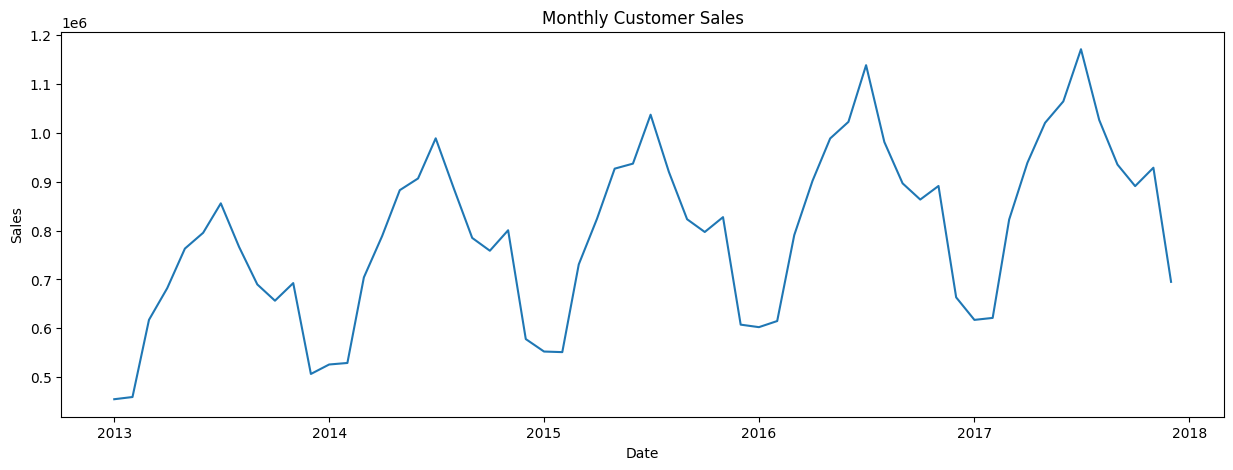

In [131]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["date"],monthly_sales["sales"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

In [132]:
#lets show the sales diffrences between the months

In [133]:
monthly_sales["sales_diff"]=monthly_sales["sales"].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(5)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


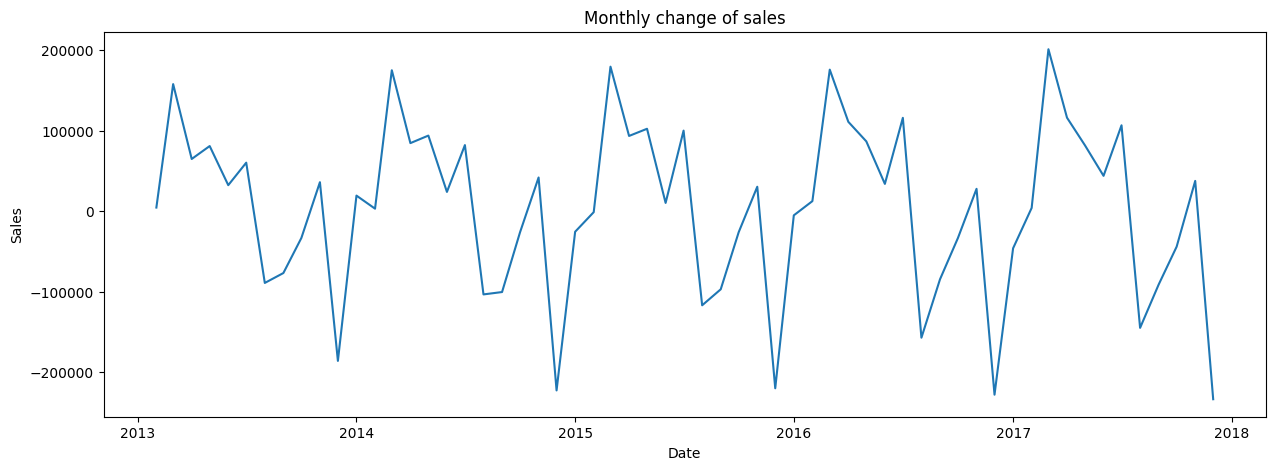

In [134]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["date"],monthly_sales["sales_diff"])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly change of sales")
plt.show()

In [135]:
#train to predict the sales on next month/ dropp of sales and date

In [136]:
supervised_data=monthly_sales.drop(["date","sales"],axis=1)
supervised_data.head(12) # that equals 1 year

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


In [137]:
#first 12 month as input and second 12 month summ as label

In [138]:
for i in range(1,13):
  col_name="month_"+str(i)
  supervised_data[col_name]=supervised_data["sales_diff"].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [139]:
#split data into train and test data preprocessing

In [140]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print("Train data shape",train_data.shape)
print("Test data shape",test_data.shape)

Train data shape (35, 13)
Test data shape (12, 13)


In [141]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [142]:
x_train,y_train=train_data[:,1:],train_data[:,0:1]
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("y_test shape:",y_test.shape)

x_train shape: (35, 12)
y_train shape: (35,)
x_test shape: (12, 12)
y_test shape: (12,)


In [143]:
#prediction dataframe to mereg predicted sales price of all tranied algo

In [144]:
sales_dates=monthly_sales["date"][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [145]:
act_sales=monthly_sales["sales"][-13:].to_list() #sales in last 13 month
act_sales

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

In [146]:
#linear regression forecast

In [147]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre= lr_model.predict(x_test)


In [148]:
lr_pre=lr_pre.reshape(-1,1)#created lr prediction
lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)#matrix with input features of test data and predicted output
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)
lr_pre_test_set

array([[ -15496.21493431, -228037.        ,   27811.        ,
         -33194.        ,  -84663.        , -157224.        ,
         116054.        ,   33934.        ,   86780.        ,
         111069.        ,  175924.        ,   12518.        ,
          -5133.        ],
       [  11031.37815765,  -46105.        , -228037.        ,
          27811.        ,  -33194.        ,  -84663.        ,
        -157224.        ,  116054.        ,   33934.        ,
          86780.        ,  111069.        ,  175924.        ,
          12518.        ],
       [ 198150.00014217,    4063.        ,  -46105.        ,
        -228037.        ,   27811.        ,  -33194.        ,
         -84663.        , -157224.        ,  116054.        ,
          33934.        ,   86780.        ,  111069.        ,
         175924.        ],
       [ 120972.12302654,  201298.        ,    4063.        ,
         -46105.        , -228037.        ,   27811.        ,
         -33194.        ,  -84663.        , -157224

In [149]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
 result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series=pd.Series(result_list,name="Linear Prediction")
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [150]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [151]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"],monthly_sales["sales"][-12:]))
lr_mae=mean_absolute_error(predict_df["Linear Prediction"],monthly_sales["sales"][-12:])
lr_r2=r2_score=(predict_df["Linear Prediction"],monthly_sales["sales"][-12:])
print("Linear Regression MSE:",lr_mse)
print("Linear Regression MAE:",lr_mae)
print("Linear Regression R2:",lr_r2)

Linear Regression MSE: 16221.272385416869
Linear Regression MAE: 12433.184266490736
Linear Regression R2: (0     6.479148e+05
1     6.283374e+05
2     8.195190e+05
3     9.436391e+05
4     1.033653e+06
5     1.065286e+06
6     1.201561e+06
7     1.002123e+06
8     9.415142e+05
9     9.080646e+05
10    9.167461e+05
11    6.947978e+05
Name: Linear Prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


In [150]:
#visualize the predictio to av-ctual sales

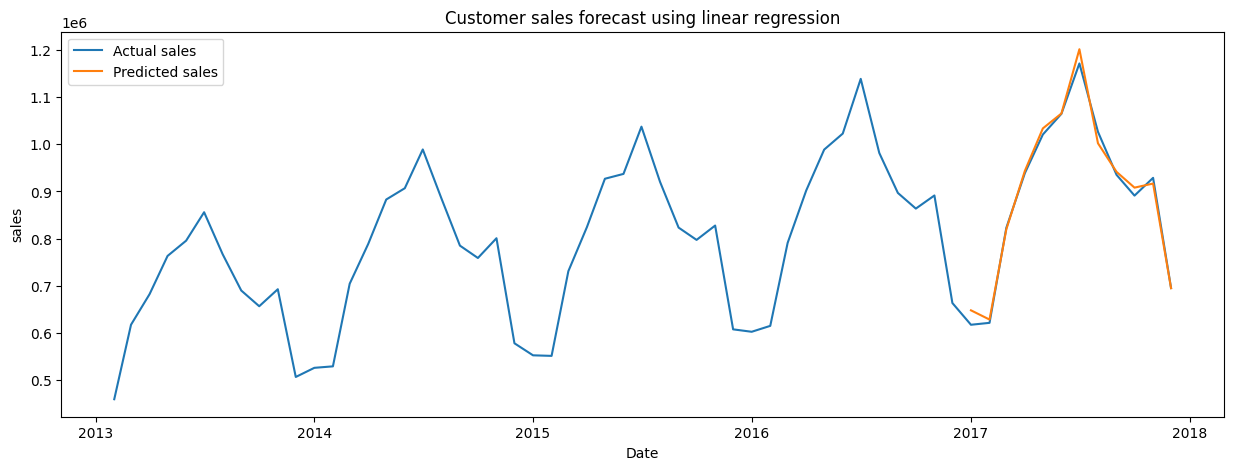

In [154]:
plt.figure(figsize=(15,5))
#actual sales
plt.plot(monthly_sales["date"],monthly_sales["sales"])
#predicted sales
plt.plot(predict_df["date"],predict_df["Linear Prediction"])
plt.title("Customer sales forecast using linear regression")
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(["Actual sales","Predicted sales"])
plt.show()
